<a href="https://colab.research.google.com/github/joaochenriques/2021-code-smells/blob/main/savitzky_golay_filter_V01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
import matplotlib.pyplot as mpl
import numpy as np
import scipy.signal
import pathlib, subprocess
from mpmath import mp

mp.dps = 200 # number of digits
print(mp)

Mpmath settings:
  mp.prec = 668               [default: 53]
  mp.dps = 200                [default: 15]
  mp.trap_complex = False     [default: False]


In [74]:
def cmdcall( cmd, verbose=True ):
    output = subprocess.getoutput( cmd )
    if verbose: print(output)

In [75]:
if not pathlib.Path("mpl_utils.py").exists():
    cmdcall( "curl -O https://raw.githubusercontent.com/joaochenriques/ipynb_libs/main/mpl_utils.py" ) 

import mpl_utils as mut
mut.config_plots()

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

mpl.rcParams["figure.figsize"] = (6,4.5)

In [76]:
def calc_coeff(num_points, pol_degree, diff_order=0):

    """ calculates filter coefficients for symmetric savitzky-golay filter.
        Based on http://www.nrbook.com/a/bookcpdf/c14-8.pdf

        num_points - filter size = 2*num_points+1 

        pol_degree   is degree of fitting polynomial

        diff_order   is degree of implicit differentiation.
                     0 - filter smooths the function
                     1 - filter smooths the first derivative 
                     n - filter smooths the n-th derivative
    """

    # setup interpolation matrix
    # ... you might use other interpolation points
    # and maybe other functions than monomials ....
    mo = mp.mpf(-1)

    x = mp.arange( -num_points, num_points+1 )

    A = mp.zeros( 2*num_points+1, pol_degree+1 )
    for i in range(2*num_points+1):
        for j in range(pol_degree+1):
            A[i,j] = x[i]**mp.mpf(j)

    # calculate diff_order-th row of inv(A^T A)
    ATA = A.transpose() * A
    rhs = mp.zeros( pol_degree+1, 1 )
    rhs[diff_order] = mo**mp.mpf( diff_order )
    wvec = mp.lu_solve( ATA, rhs )

    # calculate filter-coefficients
    coeff = A * wvec

    return np.array( coeff, dtype=float )

In [77]:
def FilterSignal( coeffs, time, unf_signal ):

  NS = unf_signal.shape[0]
  NC = coeffs.shape[0]

  assert( NC % 2 > 0 ) # assert that is a centred filter (odd)

  flt_signal = np.convolve( unf_signal, coeffs, 'valid')
  hNC = int( NC / 2 )
  flt_time = time[ hNC: NS-hNC ]

  assert( flt_time.shape[0] == flt_signal.shape[0] )

  return flt_time, flt_signal

In [78]:
def FilterResponse( LPF_coefs, points = 6000, lowpow = -6, highpow = 0 ):

  NT = LPF_coefs.shape[0]
  delta_f = 1.0 / points

  m  = int( ( NT-1 ) / 2 )
  omega_star = np.zeros( points )
  H = np.zeros( points )

  a = highpow - lowpow
  js = ( -1J * np.pi ) * np.linspace( -m, m, 2*m+1 )

  for i in range( points ):
    omega_star[i] = 10**(a * delta_f * i + lowpow )
    eiwt = np.exp( omega_star[i] * js )
    G = np.dot( LPF_coefs, eiwt )
    H[i] = np.real( G )

  return omega_star, H

In [84]:
def PlotFilterSpecs( LP_coefs, fsample ):

    NT = LP_coefs.shape[0]
    m  = int( ( NT-1 ) / 2 )

    LP_omega, LP_H = FilterResponse( LP_coefs )
    LP_omega *= fsample
    
    fig, (ax1) = mpl.subplots(1,1, figsize=(6, 4.5) )
    fig.subplots_adjust( wspace = 0.17 )

    lbl= r"$m=%i$, $f_\mathrm{s}=%.1f\,$Hz" % ( m, fsample )
    ax1.semilogy( LP_omega, LP_H, label = lbl )
    ax1.legend(fontsize=12)
    ax1.grid()
    ax1.set_xlabel('Frequency [Hz]')
    ax1.set_ylabel('Filter gain [-]')
    ax1.set_xlim( (0,60) )
    # ax2.plot( LP_omega, LP_H )
    # ax2.grid()
    # ax2.set_xlabel('frequency [Hz]')
    # ax2.set_ylabel('Filter gain [-]')

    # filename = 'Low_Pass_Filter'
    # mpl.savefig( filename + '.pdf', bbox_inches='tight', pad_inches=0.02 )

In [98]:
coeffs_6th = calc_coeff( 101, 6 )
coeffs_41th = calc_coeff( 301, 41 )

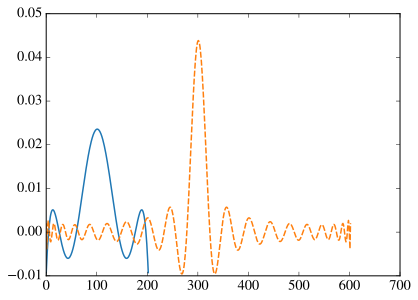

In [99]:
mpl.plot( coeffs_6th )
mpl.plot( coeffs_41th )

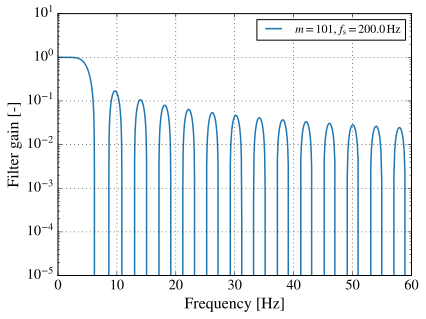

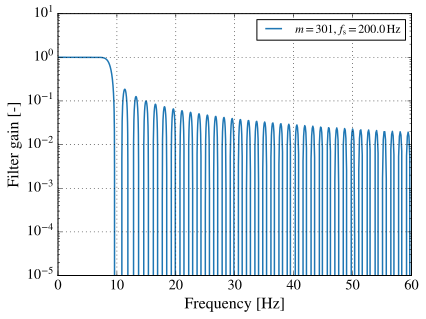

In [100]:
PlotFilterSpecs( coeffs_6th, 200 )
PlotFilterSpecs( coeffs_41th, 200 )